In [1]:
from matplotlib import pyplot as plt
from itertools import product
import seaborn as sns
import numpy as np
import pandas as pd
import os.path as op
import argparse
import re
# EEG utilities
import mne
from pycrostates.cluster import ModKMeans
from pycrostates.io import read_cluster, ChData
# BIDS utilities
from util.io.bids import DataSink
from bids import BIDSLayout

In [2]:
# constants
BIDS_ROOT = '../data/bids'
DERIV_ROOT = op.join(BIDS_ROOT, 'derivatives')
TASK = 'pitch'
MIN_TRIAL_CUTOFF = 100 # subjects must have this many trials in *every* condition to be included

layout = BIDSLayout(BIDS_ROOT, derivatives = True)

/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


In [3]:
# get filenames for subject-level microstates
fpaths = layout.get(return_type = 'filename', desc = 'microstates')
# and sort by subject number
sub_num = lambda f: int(re.findall('sub-(\w+)_', f)[0])
fpaths.sort(key = sub_num)

In [4]:
# load cluster centers for individually computed miscrostates
clusts_indiv = [read_cluster(f) for f in fpaths]
centers_indiv = [clust.cluster_centers_ for clust in clusts_indiv]
group_cluster_centers = np.vstack(centers_indiv).T
group_cluster_centers = ChData(group_cluster_centers, clusts_indiv[0].info)
# drop channel marked as Iz in first subject, since this electrode
# has an inconsistent location between subjects (sometimes placed at FCz)
group_cluster_centers = group_cluster_centers.pick(None, exclude = ['Iz'])

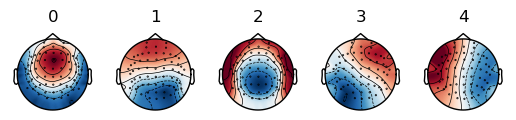

<Figure size 640x480 with 0 Axes>

In [138]:
# group level clustering
ModK = ModKMeans(n_clusters = 5, random_state = 0)
ModK.fit(group_cluster_centers, n_jobs = -1)
ModK.plot()
plt.show()
plt.savefig('microstate-topos.jpeg', dpi = 300, bbox_inches = 'tight')

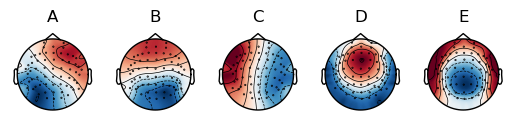

<Figure size 640x480 with 0 Axes>

In [143]:
# re-order based on visual similarity to canonical microstates topographies 
ModK.reorder_clusters(order = [3, 1, 4, 0, 2])
ModK.rename_clusters(new_names = ['A', 'B', 'C', 'D', 'E'])
# ModK.invert_polarity([False, False, False, False, False]) # only affects visualization
ModK.plot()
plt.savefig('microstate-topos.jpeg', dpi = 300, bbox_inches = 'tight')
plt.show()

In [61]:
# save solution
clust_fpath = op.join(DERIV_ROOT, 'microstates', 'clusters_group.fif.gz')
ModK.save(clust_fpath)

In [8]:
subs = layout.get_subjects()
subs.sort(key = int)
sub = subs[11]

In [9]:
def read_epochs(sub, desc):
    '''
    reads and concatenates epochs across runs
    '''
    layout = BIDSLayout(BIDS_ROOT, derivatives = True)
    run = lambda f: int(re.findall('run-(\w+)_', f)[0])
    fnames = layout.get(
        return_type = 'filename',
        subject = sub, desc = desc
        )
    fnames.sort(key = run)
    epochs_all = [mne.read_epochs(f) for f in fnames]
    epochs = mne.concatenate_epochs(epochs_all)
    epochs = epochs.pick('eeg')
    return epochs

In [10]:
def compute_spectrum_dB(epo):
    '''
    Computes power spectrum of frequency following response
    '''
    assert(epo.tmin == -epo.tmax)
    poststim = epo.average().compute_psd(tmin = 0., tmax = None)
    baseline = epo.average().compute_psd(tmin = None, tmax = 0.)
    power = 10 * np.log10(poststim.get_data() / baseline.get_data())
    power = np.squeeze(power)
    return poststim.freqs, power

In [144]:
subs = layout.get_subjects(scope = 'microstates')
subs.sort(key = int)

params = list()
all_spectrums = list()

for sub in subs:
    print(f'sub: {sub}')

    # get last microstate observed before each stimulus is delivered
    epochs = read_epochs(sub, 'forMicrostate')
    segmentation = ModK.predict(epochs, reject_edges = False)
    labels = [segmentation.cluster_names[idx] for idx in segmentation.labels[:, -1]]
    
    # Save params
    d = segmentation.compute_parameters()
    d["sub"] = sub
    params.append(d)

    # read FFR epochs and assign microstate labels
    epochs = read_epochs(sub, 'forFFR')
    mapping = {epochs.event_id[key]: key for key in epochs.event_id}
    event_names = np.array([mapping[ev] for ev in epochs.events[:, -1]])
    df = pd.DataFrame({'stimulus': event_names, 'microstate': labels})
    epochs.metadata = df

    # compute FFR spectrums for each microstate x stim
    micros = segmentation.cluster_names
    print(micros)
    stims = np.unique(event_names)
    for microstate, stim in product(micros, stims):
        try:
            epo = epochs["microstate == '%s'"%microstate][stim]
        except:
            print(f'Sub {sub} is missing event tags {stim}!')
            continue
        freqs, spectrum = compute_spectrum_dB(epo)
        df = pd.DataFrame(
            {'subject': sub,
             'stimulus': int(stim),
             'microstate': microstate,
             'frequency': freqs,
             'power': spectrum
            }
        )
        df['trials'] = epo.events.shape[0]
        all_spectrums.append(df)

# compile into one big dataframe
spectrums = pd.concat(all_spectrums)

# Add target column
spectrums['tag'] = spectrums.stimulus
target = []
stimulus = []
freqs = [130, 200, 280]
for stim in spectrums.tag:
    target_tag = int(str(tag)[0])
    stimulus_tag = int(str(tag)[1])
    target.append(freqs[target_tag - 1]) # convert to hz
    stimulus.append(freqs[stimulus_tag - 1])
spectrums['target'] = target
spectrums['stimulus'] = stimulus

# Save for later
spectrums.to_csv('spectrums.csv', sep = '\t', index = True)

# Load saved spectrums
spectrums = pd.read_csv('spectrums.csv', sep = '\t', index_col = 0)
spectrums

sub: 3


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "
/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['A', 'B', 'C', 'D', 'E']
sub: 4


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "
/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['A', 'B', 'C', 'D', 'E']
sub: 5


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "
/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['A', 'B', 'C', 'D', 'E']
sub: 6


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "
/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['A', 'B', 'C', 'D', 'E']
sub: 7


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "
/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['A', 'B', 'C', 'D', 'E']
sub: 8


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "
/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['A', 'B', 'C', 'D', 'E']
sub: 9


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "
/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['A', 'B', 'C', 'D', 'E']
sub: 10


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "
/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['A', 'B', 'C', 'D', 'E']
sub: 11


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "
/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['A', 'B', 'C', 'D', 'E']
sub: 12


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "
/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['A', 'B', 'C', 'D', 'E']
sub: 13


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "
/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['A', 'B', 'C', 'D', 'E']
sub: 14


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "
/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['A', 'B', 'C', 'D', 'E']
sub: 15


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "
/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['A', 'B', 'C', 'D', 'E']
sub: 16


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "
/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['A', 'B', 'C', 'D', 'E']
sub: 18


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "
/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['A', 'B', 'C', 'D', 'E']
sub: 19


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "
/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['A', 'B', 'C', 'D', 'E']
sub: 20


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "
/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['A', 'B', 'C', 'D', 'E']
sub: 21


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "
/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['A', 'B', 'C', 'D', 'E']
sub: 22


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "
/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['A', 'B', 'C', 'D', 'E']
sub: 23


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "
/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['A', 'B', 'C', 'D', 'E']
sub: 24


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "
/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['A', 'B', 'C', 'D', 'E']
sub: 25


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "
/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['A', 'B', 'C', 'D', 'E']
sub: 26


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "
/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['A', 'B', 'C', 'D', 'E']
sub: 27


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "
/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['A', 'B', 'C', 'D', 'E']
sub: 28


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "
/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['A', 'B', 'C', 'D', 'E']
sub: 29


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "
/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['A', 'B', 'C', 'D', 'E']
sub: 30


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "
/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['A', 'B', 'C', 'D', 'E']
sub: 31


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "
/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['A', 'B', 'C', 'D', 'E']
sub: 32


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "
/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['A', 'B', 'C', 'D', 'E']
sub: 33


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "
/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['A', 'B', 'C', 'D', 'E']
sub: 34


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "
/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['A', 'B', 'C', 'D', 'E']
sub: 35


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "
/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['A', 'B', 'C', 'D', 'E']
sub: 36


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "
/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['A', 'B', 'C', 'D', 'E']
sub: 37


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "
/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['A', 'B', 'C', 'D', 'E']
sub: 38


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "
/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['A', 'B', 'C', 'D', 'E']
sub: 39


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "
/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['A', 'B', 'C', 'D', 'E']
sub: 40


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "
/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['A', 'B', 'C', 'D', 'E']
sub: 41


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "
/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['A', 'B', 'C', 'D', 'E']
sub: 42


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "
/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['A', 'B', 'C', 'D', 'E']
sub: 43


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "
/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['A', 'B', 'C', 'D', 'E']
Sub 43 is missing event tags 11!
Sub 43 is missing event tags 12!
Sub 43 is missing event tags 13!
Sub 43 is missing event tags 21!
Sub 43 is missing event tags 22!
Sub 43 is missing event tags 23!
Sub 43 is missing event tags 31!
Sub 43 is missing event tags 32!
Sub 43 is missing event tags 33!
Sub 43 is missing event tags 21!
Sub 43 is missing event tags 22!
Sub 43 is missing event tags 23!
Sub 43 is missing event tags 31!
Sub 43 is missing event tags 32!
Sub 43 is missing event tags 33!
Sub 43 is missing event tags 11!
Sub 43 is missing event tags 12!
Sub 43 is missing event tags 13!
Sub 43 is missing event tags 21!
Sub 43 is missing event tags 22!
Sub 43 is missing event tags 23!
Sub 43 is missing event tags 31!
Sub 43 is missing event tags 32!
Sub 43 is missing event tags 33!
Sub 43 is missing event tags 11!
Sub 43 is missing event tags 13!
Sub 43 is missing event tags 21!
Sub 43 is missing event tags 22!
Sub 43 is missing event tags 23!
Sub 43 is missing

/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "
/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['A', 'B', 'C', 'D', 'E']
sub: 45


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "
/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['A', 'B', 'C', 'D', 'E']


,subject,stimulus,microstate,frequency,power,trials,target
0,3,11,A,0.000000,0.228096,95,1
1,3,11,A,3.324100,0.166520,95,1
2,3,11,A,6.648199,0.080820,95,1
3,3,11,A,9.972299,0.448082,95,1
4,3,11,A,13.296399,0.399966,95,1
...,...,...,...,...,...,...,...
176,45,33,E,585.041551,0.133931,107,3
177,45,33,E,588.365651,0.516253,107,3
178,45,33,E,591.689751,0.256135,107,3
179,45,33,E,595.013850,-0.095613,107,3


In [163]:
# excluded = np.unique(spectrums.subject[spectrums.trials < MIN_TRIAL_CUTOFF])
# print(excluded)
# spectrums = spectrums[~spectrums.subject.isin(excluded)]
excluded = [43]
spectrums = spectrums[~spectrums.subject.isin(excluded)]
np.unique(spectrums.subject)

array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20,
       21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37,
       38, 39, 40, 41, 42, 44, 45])

In [186]:
## we can do ANOVAa seperately for each stimulus 
## so long as we correct for multiple comparisons, anyway,
## but it feels kind of silly...

all_stims_power = []
stim_freqs = [130, 200, 280]

for stim_freq in stim_freqs:
    print(stim_freq)
    
    print('\n%d Hz stimulus:'%stim_freq)

    # select Fourier frequency nearest to stimulus frequency 
    idx = np.abs(spectrums.frequency - stim_freq).argmin()
    hz = spectrums.frequency[idx].iloc[0]
    power_f0 = spectrums[spectrums.frequency == hz]
    power_f0 = power_f0[power_f0.stimulus == stim_freq]

    all_stims_power.append(power_f0)
    
    # perform a repeated measures anova 
    from statsmodels.stats.anova import AnovaRM
    aov = AnovaRM(
        data = power_f0, 
        depvar = 'power',
        subject = 'subject', 
        within = ['microstate', 'target']
    )
    res = aov.fit()
    print(res)
#     break
    

130

130 Hz stimulus:
                     Anova
                  F Value Num DF  Den DF  Pr > F
------------------------------------------------
microstate         1.0061 4.0000 160.0000 0.4061
target             6.4205 2.0000  80.0000 0.0026
microstate:target  0.9980 8.0000 320.0000 0.4374

200

200 Hz stimulus:
                     Anova
                  F Value Num DF  Den DF  Pr > F
------------------------------------------------
microstate         0.7098 4.0000 160.0000 0.5864
target             0.3441 2.0000  80.0000 0.7099
microstate:target  0.5677 8.0000 320.0000 0.8042

280

280 Hz stimulus:
                     Anova
                  F Value Num DF  Den DF  Pr > F
------------------------------------------------
microstate         0.0908 4.0000 160.0000 0.9852
target             1.1491 2.0000  80.0000 0.3221
microstate:target  0.3877 8.0000 320.0000 0.9269



In [188]:
## better to just add a fixed effect for stimulus frequency 
power_f0 = pd.concat(all_stims_power)
aov = AnovaRM(
    data = power_f0, 
    depvar = 'power',
    subject = 'subject', 
    within = ['microstate', 'target', 'stimulus']
)
res = aov.fit()
print(res)

                          Anova
                           F Value  Num DF  Den DF  Pr > F
----------------------------------------------------------
microstate                  0.5772  4.0000 160.0000 0.6796
target                      4.9900  2.0000  80.0000 0.0091
stimulus                    8.6019  2.0000  80.0000 0.0004
microstate:target           1.1137  8.0000 320.0000 0.3534
microstate:stimulus         0.6457  8.0000 320.0000 0.7390
target:stimulus             2.0148  4.0000 160.0000 0.0949
microstate:target:stimulus  0.4294 16.0000 640.0000 0.9750



In [69]:
import dabest


def plot(stim):

    dat = []
    
    fig = plt.figure(figsize = (12, 4))
    gs = fig.add_gridspec(2, 3, wspace = .35)
        
    kwargs = dict(
        data = power_f0[power_f0.stimulus == stim], 
        x = 'microstate',
        y = 'power',
        paired = 'baseline', 
        id_col = 'subject'
    )
    data = dabest.load(
        idx = ['A', 'B', 'C', 'D'],
        **kwargs
    )
    dat.append(data)
    axs = fig.add_subplot(gs[:, 0])
    data.cohens_d.plot(ax = axs, contrast_ylim = (-.7, .7))
    
    data = dabest.load(
        idx = ['B', 'C', 'D'],
        **kwargs
    )
    dat.append(data)
    axs = fig.add_subplot(gs[:, 1])
    data.cohens_d.plot(ax = axs, contrast_ylim = (-.7, .7))
    
    data = dabest.load(
        idx = ['C', 'D'],
        **kwargs
    )
    dat.append(data)
    axs = fig.add_subplot(gs[:, 2])
    data.cohens_d.plot(ax = axs, contrast_ylim = (-.7, .7), float_contrast = False)
    
    plt.savefig('%dhz-paired-differences.jpeg'%stim_freq, dpi = 300, bbox_inches = 'tight')
    plt.show()
    return dat

In [72]:
power_f0

,subject,stimulus,microstate,frequency,power,trials
39,3,11,0,129.639889,1.350162,117
39,3,11,1,129.639889,0.482475,99
39,3,11,2,129.639889,1.197406,151
39,3,11,3,129.639889,0.381341,95
39,3,11,4,129.639889,4.373432,100
...,...,...,...,...,...,...
84,42,33,0,279.224377,5.090524,53
84,42,33,1,279.224377,5.727148,132
84,42,33,2,279.224377,4.659900,51
84,42,33,3,279.224377,3.850390,98


In [71]:
data = dict()
for stim in stim_to_stim_freq.keys():
    data[i] = plot(stim)

/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/dabest/_classes.py:238: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if g not in data_in[x].unique():


IndexError: "A" is not a group in the column `microstate`. Please check `idx` and try again.

<Figure size 1200x400 with 0 Axes>

In [ ]:
from matplotlib.lines import Line2D

# average dB scale FFR spectrums across subjects
ffrs = spectrums.groupby(['stimulus', 'frequency']).mean()

# and plot 
fig, ax = plt.subplots()
for stim in [50, 100, 150, 200, 250]:
    p = ax.plot(ffrs.loc[stim].index, ffrs.loc[stim].power)
    c = p[-1].get_color()
    ax.axvline(stim, color = c, linestyle = '--')
legend_elements = [
    Line2D([0], [0], color = 'black', linestyle = '--', label = 'stimulus frequency'),
    Line2D([0], [0], color = 'black', linestyle = '-', label = 'frequency following response'),
    ]
ax.legend(handles = legend_elements, loc = 'upper left')
ax.set_xlabel('frequency')
ax.set_ylabel('power (dB)')
plt.savefig('FFRs.jpeg', dpi = 300, bbox_inches = 'tight')
plt.show()

In [ ]:
# bootstrap 95% confidence interval for Cohen's d effect sizes 
data[50][0].cohens_d.results[['control', 'test', 'bca_low', 'difference', 'bca_high', 'pvalue_permutation']]

In [ ]:
data[50][1].cohens_d.results[['control', 'test', 'bca_low', 'difference', 'bca_high', 'pvalue_permutation']]

In [ ]:
data[150][1].cohens_d.results[['control', 'test', 'bca_low', 'difference', 'bca_high', 'pvalue_permutation']]

In [ ]:
data[200][1].cohens_d.results[['control', 'test', 'bca_low', 'difference', 'bca_high', 'pvalue_permutation']]

### Global Explained Variance

In [ ]:
data = [
    [d['A_gev'], d['B_gev'], d['C_gev'], d['D_gev']]
    for d in params
]

plt.violinplot(np.array(data))
plt.title("Global Explained Variance (%)")
plt.xticks(
    ticks=range(1, len(ModK.cluster_names) + 1),
    labels=ModK.cluster_names,
)
plt.ylim([0, 0.40])
plt.savefig('microstate-GEV.jpeg', dpi = 300, bbox_inches = 'tight')
plt.show()

print(f'Means: {np.mean(data, axis = 0)}')
print(f'Sd: {np.std(data, axis = 0)}')

### Get means and sds following each microstates

In [ ]:
power_f0.groupby(['stimulus', 'microstate'])['power'].mean()

In [ ]:
power_f0.groupby(['stimulus', 'microstate'])['power'].std()